<a href="https://colab.research.google.com/github/Gibsdevops/ML_tensorflowLite/blob/main/tflite_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0


In [1]:
import os
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.15.0'

In [3]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


Data preprocessing
Use TensorFlow Datasets to load the cats and dogs dataset.

This tfds package is the easiest way to load pre-defined data. If you have your own data, and are interested in importing using it with TensorFlow see loading image data

In [4]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

The tfds.load method downloads and caches the data, and returns a tf.data.Dataset object. These objects provide powerful, efficient methods for manipulating data and piping it into your model.

Since "cats_vs_dogs" doesn't define standard splits, use the subsplit feature to divide it into (train, validation, test) with 80%, 10%, 10% of the data respectively.

In [9]:
(train_examples, validation_examples, test_examples), info = tfds.load(
    'cats_vs_dogs',
    split=['train[80%:]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Format the Data

Use the tf.image module to format the images for the task.

Resize the images to a fixes input size, and rescale the input channels




In [16]:
#function for formating

def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) /255.0
  return image, label

In [17]:
#shuffle and batch the data

BATCH_SIZE =32

train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(BATCH_SIZE)



In [18]:
#inspect the batchs

for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 224, 224, 3])

Defining the model

All it takes is to put a linear classifier on top of the feature_extractor_layer with the Hub module.

For speed, we start out with a non-trainable feature_extractor_layer, but you can also enable fine-tuning for greater accuracy.

In [19]:
do_fine_tuning = False

In [21]:
feature_extractor = hub.KerasLayer(
    MODULE_HANDLE,
    input_shape = IMAGE_SIZE + (3,),
    output_shape=[FV_SIZE],
    trainable = do_fine_tuning
)

In [22]:
#builde the model

model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


unfreezing some layers

In [30]:
num_layers = 7
do_fine_tuning = False

if do_fine_tuning == True:
  feature_extractor.trainable = True

  for layer in model.layers[:num_layers]:
    layer.trainable = True

else:
  feature_extractor = False

In [31]:
if do_fine_tuning==True:
  model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
  print("trainable layers ")
else:
  model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
  print("no trainable layers ")

no trainable layers 


In [32]:
EPOCHS = 5
hist = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
146/146 [==============================] - 686s 5s/step - loss: 0.2723 - accuracy: 0.9306 - val_loss: 0.5747 - val_accuracy: 0.9179
Epoch 2/5
146/146 [==============================] - 709s 5s/step - loss: 0.1884 - accuracy: 0.9589 - val_loss: 0.1894 - val_accuracy: 0.9635
Epoch 3/5
146/146 [==============================] - 680s 5s/step - loss: 0.1686 - accuracy: 0.9706 - val_loss: 0.1252 - val_accuracy: 0.9841
Epoch 4/5
146/146 [==============================] - 677s 5s/step - loss: 0.1529 - accuracy: 0.9759 - val_loss: 0.1250 - val_accuracy: 0.9862
Epoch 5/5
146/146 [==============================] - 681s 5s/step - loss: 0.1376 - accuracy: 0.9811 - val_loss: 0.1486 - val_accuracy: 0.9798


In [33]:
#eport the model

cats_vs_dogs_saved_model = "exp_saved_model"

In [34]:
#export the saved model
tf.saved_model.save(model, cats_vs_dogs_saved_model)

this command prints detailed information about the default serving signature of your "Cats vs. Dogs" TensorFlow SavedModel, including its expected inputs and outputs. This is a crucial step for debugging and understanding what a SavedModel expects when you try to use it for inference.

In [35]:
%%bash -s $cats_vs_dogs_saved_model
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


2025-06-15 10:46:18.109905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-15 10:46:18.109978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-15 10:46:18.112345: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-15 10:46:19.767076: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-06-15 10:46:22.489601: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the gui

In [36]:
loaded = tf.saved_model.load(cats_vs_dogs_saved_model)

 this code snippet is used to programmatically inspect the input and output requirements and available functions of a TensorFlow SavedModel after it has been loaded into memory

In [37]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense')}


**Convert using TFLite's Converter**


Load the TFLiteConverter with the SavedModel

In [39]:
converter = tf.lite.TFLiteConverter.from_saved_model(cats_vs_dogs_saved_model)

In [40]:
#post training quantization
#Set Optimizations:

converter.optimization = [tf.lite.Optimize.DEFAULT]

In [41]:
#post training integer quantization
#Provide Representative Dataset: If using full integer quantization

def representative_data_gen():
  for input_value, _ in test_batches.take(100):
    yield [input_value]

In [42]:
converter.representative_dataset = representative_data_gen

In [44]:
#full integr quantization
#Set Target Supported Types/Ops

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

FINALLY CONVERT THE MODEL

Convert the Model by calling convert() on the converter

In [46]:
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

Test the TFLite model using the Python Interpreter

In [47]:
# Load TFLite model and allocate tensors.

interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [49]:
from tqdm import tqdm

# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img_batch, label_batch in tqdm(test_batches.take(10)):
    # Iterate through each image and label in the batch
    for i in range(img_batch.shape[0]):
        img = tf.expand_dims(img_batch[i], axis=0) # Add batch dimension of 1
        label = label_batch[i]

        interpreter.set_tensor(input_index, img)
        interpreter.invoke()
        predictions.append(interpreter.get_tensor(output_index))

        test_labels.append(label.numpy())
        test_imgs.append(img_batch[i]) # Store the original image without the added batch dimension

100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


Functions for plotting

In [50]:
#@title Utility functions for plotting
# Utilities for plotting

class_names = ['cat', 'dog']

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  img = np.squeeze(img)

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)


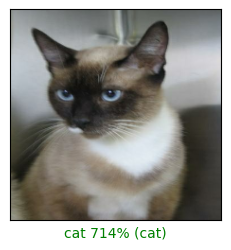

In [51]:
index = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

Download the model

In [ ]:
labels = ['cat', 'dog']

with open('labels.txt', 'w') as f:
  f.write('\n'.join(labels))

try:
  from google.colab import files
  files.download('converted_model.tflite')
  files.download('labels.txt')
except:
  pass